# Spam email detection

In [30]:
!pip3 install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import the dataset (Dataset is taken from kaggle)

In [31]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

df = pd.read_csv("/content/drive/MyDrive/Spam Email detection/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [32]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [33]:
747/4825

0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance

In [34]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [35]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [36]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [37]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [38]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [39]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
4783,ham,"Call me, i am senthil from hsbc.",0
5488,ham,K. I will sent it again,0
4683,ham,"Haha yeah, 2 oz is kind of a shitload",0
4441,ham,I've got it down to a tea. not sure which flavour,0
4407,spam,As one of our registered subscribers u can ent...,1


### Split it into training and test data set

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [41]:
X_train.head(4)

5098    TheMob>Hit the link to get a premium Pink Pant...
4566    Honeybee Said: *I'm d Sweetest in d World* God...
1743    EY! CALM DOWNON THEACUSATIONS.. ITXT U COS IWA...
2902    Ur cash-balance is currently 500 pounds - to m...
Name: Message, dtype: object

### Now lets import BERT model and get embeding vectors for few sample statements

In [42]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [43]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.51327276, -0.88845724, ..., -0.74748844,
        -0.7531474 ,  0.91964495],
       [-0.87208337, -0.5054394 , -0.94446665, ..., -0.85847497,
        -0.71745324,  0.8808295 ]], dtype=float32)>

### Get embeding vectors for few sample words. Compare them using cosine similarity

In [44]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [46]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703803]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [47]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872035]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

### Build Model

There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

In [48]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [50]:
len(X_train)

1120

In [51]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

### Training the model

In [52]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 27s 406ms/step - loss: 0.6221 - accuracy: 0.6812 - precision: 0.6809 - recall: 0.6821
Epoch 2/10
35/35 [==============================] - 14s 409ms/step - loss: 0.5048 - accuracy: 0.7946 - precision: 0.7936 - recall: 0.7964
Epoch 3/10
35/35 [==============================] - 12s 339ms/step - loss: 0.4473 - accuracy: 0.8339 - precision: 0.8327 - recall: 0.8357
Epoch 4/10
35/35 [==============================] - 11s 325ms/step - loss: 0.3963 - accuracy: 0.8723 - precision: 0.8492 - recall: 0.9054
Epoch 5/10
35/35 [==============================] - 11s 326ms/step - loss: 0.3668 - accuracy: 0.8759 - precision: 0.8574 - recall: 0.9018
Epoch 6/10
35/35 [==============================] - 11s 323ms/step - loss: 0.3420 - accuracy: 0.8902 - precision: 0.8774 - recall: 0.9071
Epoch 7/10
35/35 [==============================] - 11s 323ms/step - loss: 0.3298 - accuracy: 0.8884 - precision: 0.8680 - recall: 0.9161
Epoch 8/10
35/35 [================

In [53]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 313ms/step - loss: 0.2582 - accuracy: 0.9358 - precision: 0.9223 - recall: 0.9519


[0.25824618339538574,
 0.9358288645744324,
 0.9222797751426697,
 0.9518716335296631]

In [54]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 4s 322ms/step


In [55]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,

In [56]:
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[172,  15],
       [  9, 178]])

Text(33.0, 0.5, 'Truth')

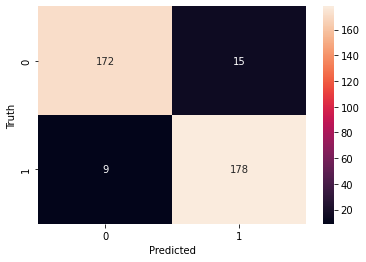

In [57]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [58]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       187
           1       0.92      0.95      0.94       187

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374



### Inference

In [59]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 724ms/step


array([[0.7718261 ],
       [0.8562139 ],
       [0.80887634],
       [0.2084548 ],
       [0.1126179 ]], dtype=float32)